Import statements in Python

In [86]:
%matplotlib notebook
import cv2
import os
from __future__ import print_function # Python 2/3 compatibility
import cv2 # Import the OpenCV library
import numpy as np # Import Numpy library
from statistics import mean
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

### Quick validation of velocity of one pixel

In [87]:
# Load an color image in grayscale
img = cv2.imread('frame0.jpg',0)

In [88]:
cv2.imshow('image',img)

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-39p1qqfs/opencv/modules/highgui/src/window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [89]:
# 88 x 37 across 1 cm with tick marks for every 1mm
# so 1mm is 
pixPerMM = 8.8 # pixel distance per mm

# do this more systematically... take the average of the brightness
# of the ruler!

In [90]:
# iphone 6 fps with slo-mo
fps = 240 # frames per second

In [91]:
# hand calculation - brief
# looking at frames: 123 to 131
numFrames = 131-123
heightPix = 1080 #from iphone settings
pixPerMM = 8.8 # pixel distance per mm

In [92]:
# mm per second
seconds = numFrames/fps 
distance = heightPix/pixPerMM
velocity = distance/seconds

In [93]:
print(seconds)

0.03333333333333333


In [94]:
print(distance) # around 4.8 inches

122.72727272727272


In [95]:
print(velocity) #mm per second

3681.8181818181815


From a quick validation test, we received around 3.681 m/s for the particle falling. Now, let us write functions in order for automatic distance calibration and additionally object detection and finding the average velocity from the centroids detected.

## Distance Calibration

To do accurate distance calibration, first position a ruler to where you expect the particles to drop. You want the ruler to have definite lines at each mm mark and put the ruler was perpendicular as possible to the surface of the table.

We recommend to take a quick 5 second video with the video stationary. We will be using one of the frames in order to calculate the pixel/mm ratio.

Please save this calibration test as a mp4 file and save into the same directory as the script.

In [96]:
nameCalibrationFile = "calibration_test.mp4"
c=cv2.VideoCapture(nameCalibrationFile)
c.isOpened()

True

In [97]:
# Function to extract frames
def calibrationImage(path):
      
    # Path to video file
    vidObj = cv2.VideoCapture(path)
  
    # Used as counter variable
    count = 0
  
    # checks whether frames were extracted
    success = 1
  
    if count == 0:
        # vidObj object calls read
        # function extract frames
        success, image = vidObj.read()
  
        # Saves the frames with frame-count
        # TODO: need to save into directory
        cv2.imwrite("testCalibration.png", image)
  
        count += 1
    

In [98]:
# Driver Code
if __name__ == '__main__':
  
    # Calling the function
    calibrationImage("calibration_test.mp4")

<IPython.core.display.Javascript object>


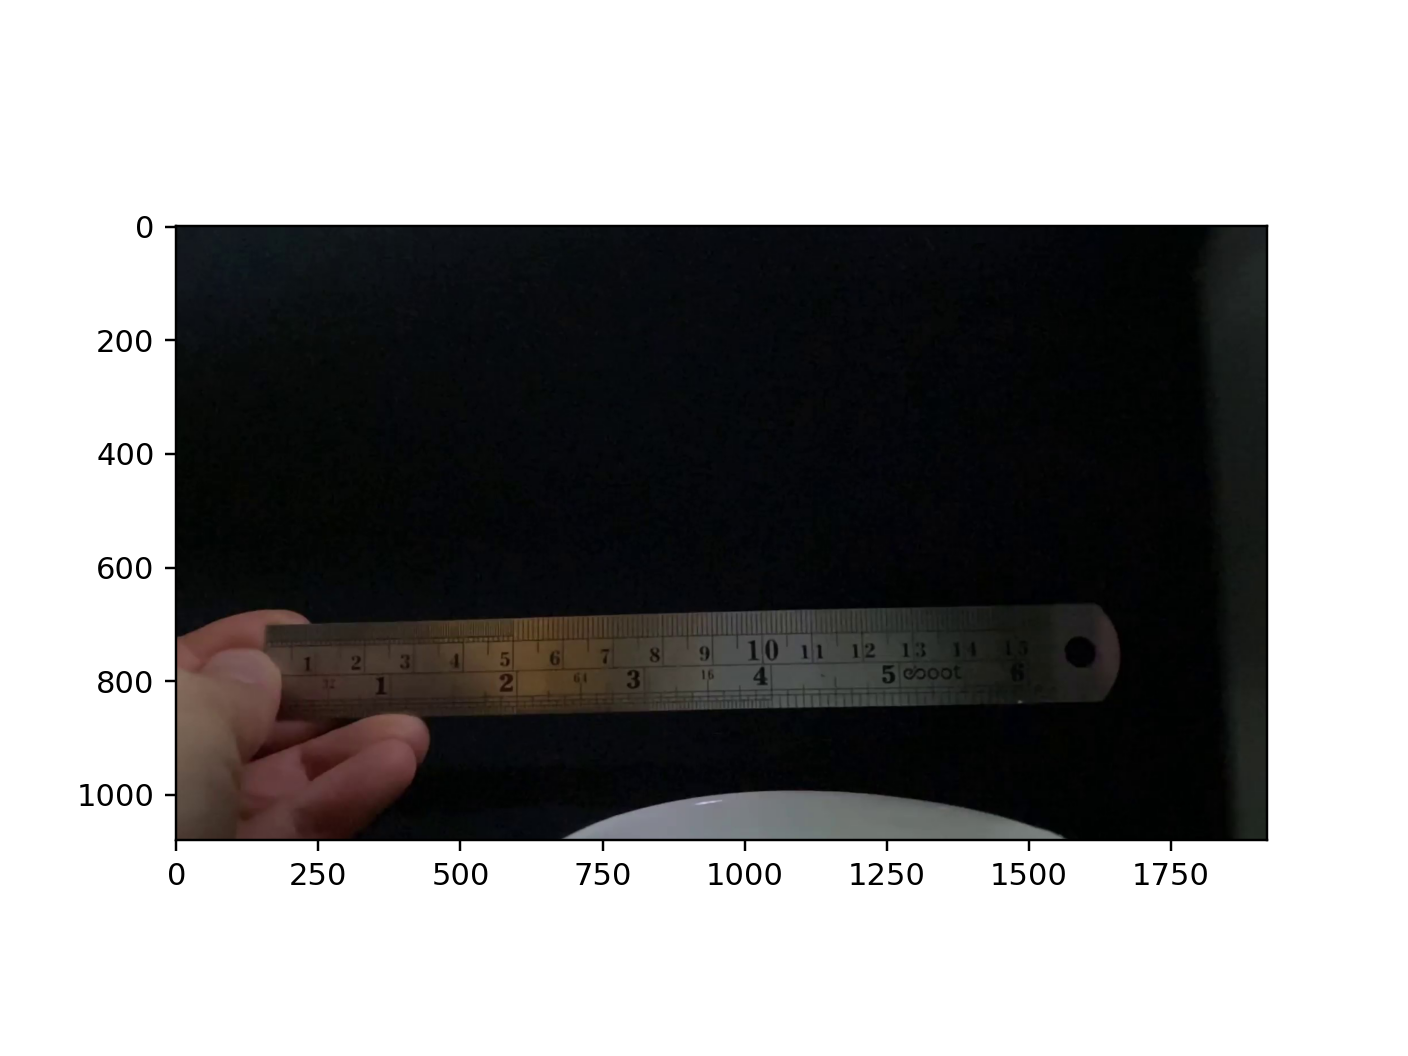

In [99]:
im = mpimg.imread('/Users/yoo-jin/git/arcticiceclinic/ImageProcessing/testCalibration.jpg')
plt.imshow(im)

Click on the left bar in order to make the image full screen. You should see pixel values as your mouse hovers on the bottom right and then use the zoom in button and write down the top left and bottom right corner of between the ruler's 1cm mark. Any 1cm mark should be fine.

For example, I found that the coordinates between 8-9cm on the ruler: 
- top left corner: (854.343, 682.21)
- bottom right corner: (946.279, 722.13)

In [100]:
topLeft = (854.343, 682.21)
bottomRight = (946.279, 722.13)

In [101]:
def distanceCalibration(calibrationIm, topLeft, bottomRight): 
    """
    Input
    calibrationIm: the image object made by imread command above
    topLeft: a tuple with the x and y coordinate for the top left 
    corner of the 1cm section of the ruler
    bottomRight: a tuple with the x and y coorindates for the bottom
    right corner of the 1cm section of the ruler
    
    Output 
    pixPerMM: pixel per mm value determined by averaged pixel values
    """
    pixPerMM = 0
    
    # Crop the image given the topLeft and bottomRight
    h = int(abs(topLeft[1] - bottomRight[1]))
    w = int(abs(topLeft[0] - bottomRight[0]))
    pixPerMM = w/10

    return pixPerMM

In [102]:
pixMM = distanceCalibration(im, topLeft, bottomRight)

In [103]:
print(pixMM)

9.1


Here, we find that the pixels per mm is 9.1.

## Object detection

Please take a slo-motion or a video of the particles falling at the highest frame rate, save as a mp4, and upload it into the same directory as where this the main script is located.

In [104]:
calibration_video_name = "pixel_test_velocity.mp4"
c=cv2.VideoCapture(calibration_video_name)
c.isOpened()

# Checking if openCV2 can open the mp4

True

In [105]:
test_video_dir = '/Users/yoo-jin/git/arcticiceclinic/ImageProcessing/pixel_test_velocity.mp4'

In [106]:
def numFramesVideo(test_video_dir):
    vidcapture = cv2.VideoCapture(test_video_dir)
    fps = vidcapture.get(cv2.CAP_PROP_FPS)
    totalNoFrames = vidcapture.get(cv2.CAP_PROP_FRAME_COUNT);
    durationInSeconds = float(totalNoFrames) / float(fps)
    return totalNoFrames, durationInSeconds

In [107]:
frames, seconds = numFramesVideo(test_video_dir)
print(frames, seconds)

463.0 15.433333333333334


In [108]:
#!/usr/bin/env python

def object_detection(threshold, video_dir, noFrames):
    """
    Input 
    threshold: pixel distance to keep track of for height and width
    video_dir: directory path to video that is wanted to be analyzed
    
    Output 
    distances (list of tuples): the captured position of the centroid 
    of the bounding box
    """
    distances = []
    i = 0
    
    # cap = cv2.VideoCapture(0)
    cap = cv2.VideoCapture(video_dir)
 
    # Create the background subtractor object
    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=True)
 
    while(True):
        i = i + 1
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        # Use every frame to calculate the foreground mask and update
        # the background
        fg_mask = fgbg.apply(frame)
 
        # Remove salt and pepper noise with a median filter
        fg_mask = cv2.medianBlur(fg_mask, 5) 
         
        # Threshold the image to make it either black or white
        thresh, fg_mask = cv2.threshold(fg_mask,127,255,cv2.THRESH_BINARY)
 
        # Find the index of the largest contour and draw bounding box
        contours, hierarchy = cv2.findContours(fg_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        areas = [cv2.contourArea(c) for c in contours]
 
        # If there are no countours
        if len(areas) < 1:
 
            # Display the resulting frame
            cv2.imshow('frame',frame)
 
            # If "q" is pressed on the keyboard, 
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
 
            # Go to the top of the while loop
            continue
 
        else:
            # Find the largest moving object in the image
            max_index = np.argmax(areas)
            
        # Draw the bounding box
        count = contours[max_index]
        x,y,w,h = cv2.boundingRect(count)
        
        # setting a threshold
        if w>threshold and h>threshold: 
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),3)
            # Draw circle in the center of the bounding box
            x2 = x + int(w/2)
            y2 = y + int(h/2)
            
            # Drawing a circle on any image
            cv2.circle(frame,(x2,y2),2,(0,0,255),-1)
            # Note that the -1 fills in the circle

            # Print the centroid coordinates
            text = "x: " + str(x2) + ", y: " + str(y2)
            cv2.putText(frame, text, (x2, y2),
                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 4)
            
            distances.append((x2, y2))
            #print(distances)
        # Display the resulting frame
        cv2.imshow('frame',frame)
        
        if i == noFrames: 
            return distances
 
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # Close down the video stream
    cap.release()
    cv2.destroyAllWindows()

In [109]:
test_video_dir = '/Users/yoo-jin/git/arcticiceclinic/ImageProcessing/pixel_test_velocity.mp4'

if __name__ == '__main__':
    #print(__doc__)
    distances = object_detection(10, test_video_dir, frames)

## Calculating velocity

In [118]:
def calculateVel(distances, pixMM, fps):
    """
    Inputs:
    distances: list of tuples containing the x and y positions
    pixMM: the pixel/mm received from distance calibration
    fps: frames per second
    Basic calculation: 
        pixel * (mm/pixel) * one frame * frame/second = mm/second
        
    Outputs:
    
    """
    velocityList = []
    for i in range(len(distances)-1):
        # pixel difference in y direction
        yPixdiff = abs(distances[i][1] - distances[i+1][1])
        
        if yPixdiff < 500: 
            velocity = yPixdiff*(1/pixMM)*1*fps
            velocityList.append(velocity)

    return mean(velocityList)

In [119]:
fps = 240
aveVel = calculateVel(distances,pixMM,fps)

In [120]:
print(aveVel)

2195.015698587127


Average velocity is around 2m/second from the given video.